In [1]:
import numpy as np
import pyro
import sim
import util
import torch
from IPython.display import clear_output
from models import GibbsSLDA, GibbsLDA, CollapsedGibbsLDA, PyroLDA

clear_output()

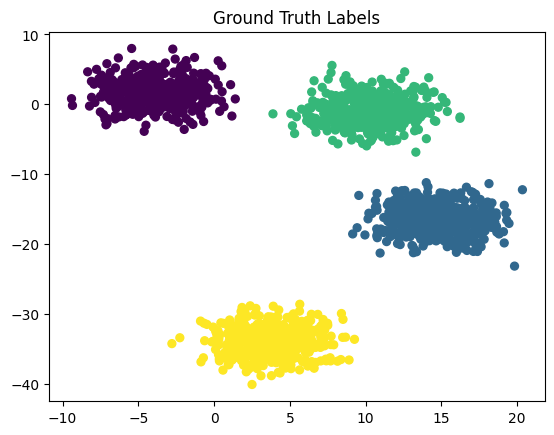

In [8]:
N_SAMPLES = 2000
N_FEATURES = 1000
N_TOPICS = 4
SCALE = 2
DISCRETIZE = False
SHUFFLE = True

if DISCRETIZE:
    X, X_labels, vocab = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
else:
    X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

100%|██████████| 20/20 [00:01<00:00, 12.09it/s]


Score: 1.0


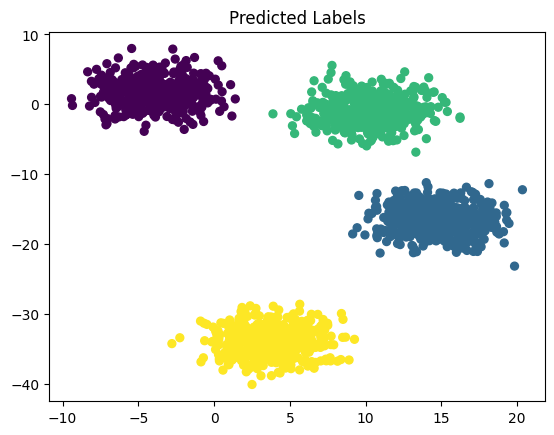

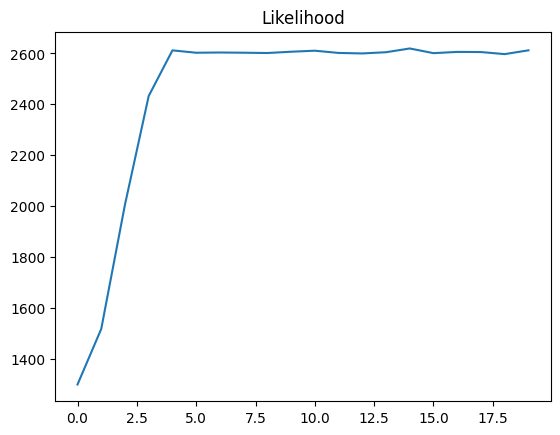

In [9]:
model = GibbsSLDA(N_TOPICS)
labels = model.fit_transform(X, 20)
Y_labels, score = util.evaluate(X_labels, labels)
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')
util.visualize_log(model.likelihood_log_, 'Likelihood')

In [6]:
from scipy.cluster.vq import kmeans, vq
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

#### Preprocessing

In [7]:
N_DOCS = 150
N_WORDS = 10
VOCAB_SIZE = 25

# Build codebook
neighbors = NearestNeighbors(n_neighbors=N_WORDS).fit(X)
_, neighbor_idx = neighbors.kneighbors(X)
codebook, _ = kmeans(X[:, 2:], VOCAB_SIZE, 100)

# Build LDA dataset
Y = np.zeros((N_SAMPLES, N_WORDS), dtype=np.int32)
for i in range(N_SAMPLES):
    Y[i], _ = vq(X[neighbor_idx, 2:][i], codebook)

# Build SLDA dataset
values = vq(X[:, 2:], codebook)[0][None].T
doc_idx = np.random.permutation(N_SAMPLES)[:N_DOCS]
doc_locs = X[doc_idx, :2]
doc_assignments = np.random.choice(N_DOCS, (N_SAMPLES, 1))
topic_assignments = np.random.choice(N_TOPICS, (N_SAMPLES, 1))
Z = np.concatenate([X[:, :2], values, doc_assignments, topic_assignments], -1)

#### Grimson Gibbs SLDA

100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


Score: 0.999


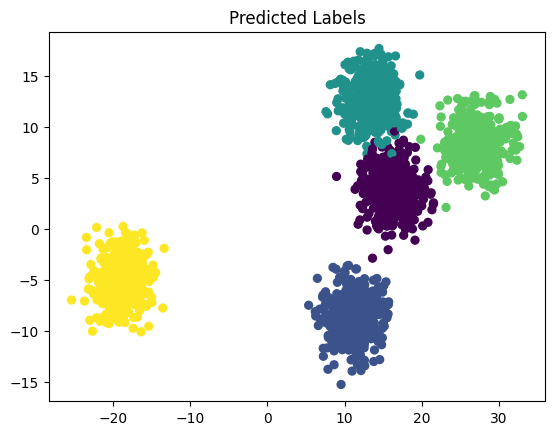

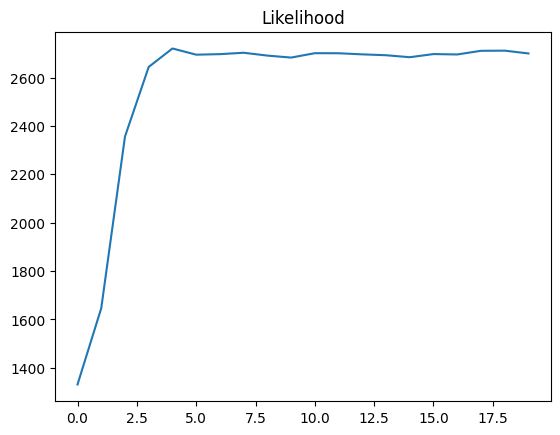

In [8]:
N_STEPS = 20
SIGMA = 1.

data = np.copy(Z)

topic_word_counts = np.zeros((N_TOPICS, VOCAB_SIZE), dtype=np.int32)
for i in range(N_TOPICS):
    idx, counts = np.unique(data[data[:, -1] == i, -3], return_counts=True)
    topic_word_counts[i, idx.astype(np.int32)] = counts

doc_topic_counts = np.zeros((N_DOCS, N_TOPICS), dtype=np.int32)
for i in range(N_DOCS):
    idx, counts = np.unique(data[data[:, -2] == i, -1], return_counts=True)
    doc_topic_counts[i, idx.astype(np.int32)] = counts

likelihood_log = []

def sample_doc(word_x, word_y, old_topic):
    probs = np.exp(-((word_x - doc_locs[:, 0])**2 + (word_y - doc_locs[:, 1])**2)/SIGMA**2)*(doc_topic_counts[:, old_topic] + 1/N_DOCS)/(doc_topic_counts + 1/N_DOCS).sum(-1)
    probs /= probs.sum()
    doc = np.random.choice(probs.shape[0], p=probs)
    likelihood_log[-1] += probs[doc]
    return doc

def sample_topic(word_value, old_doc):
    topic_word_dist = (topic_word_counts[:, word_value] + 1/N_TOPICS)/(topic_word_counts + 1/N_TOPICS).sum(-1)
    doc_topic_dist = (doc_topic_counts[old_doc] + 1/N_DOCS)/(doc_topic_counts[old_doc] + 1/N_DOCS).sum()
    probs = topic_word_dist*doc_topic_dist
    probs /= probs.sum()
    topic = np.random.choice(probs.shape[0], p=probs)
    likelihood_log[-1] += probs[topic]
    return topic

for _ in tqdm(range(N_STEPS)):
    likelihood_log.append(0.)
    for i in range(N_SAMPLES):
        (word_x, word_y), (word_value, old_doc, old_topic) = data[i, :2], data[i, -3:].astype(np.int32)
        if topic_word_counts[old_topic, word_value] < 1 or doc_topic_counts[old_doc, old_topic] < 1:
            continue
        doc_topic_counts[old_doc, old_topic] -= 1
        topic_word_counts[old_topic, word_value] -= 1
        new_topic = sample_topic(word_value, old_doc)
        new_doc = sample_doc(word_x, word_y, old_topic)
        data[i, -2], data[i, -1] = new_doc, new_topic
        doc_topic_counts[new_doc, new_topic] += 1
        topic_word_counts[new_topic, word_value] += 1

Y_labels, score = util.evaluate(X_labels, data[:, -1])
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')
util.visualize_log(likelihood_log, 'Likelihood')

#### Gibbs LDA

In [9]:
N_STEPS = 50

gibbs_lda = GibbsLDA(N_TOPICS).fit(Y, N_STEPS)
Y_labels, score = util.evaluate(X_labels, gibbs_lda.transform(Y))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')
util.visualize_log(gibbs_lda.likelihood_log_, 'Likelihood')

 20%|██        | 10/50 [00:03<00:14,  2.84it/s]


KeyboardInterrupt: 

#### Collapsed Gibbs LDA

100%|██████████| 20/20 [00:07<00:00,  2.70it/s]

Score: 1.0


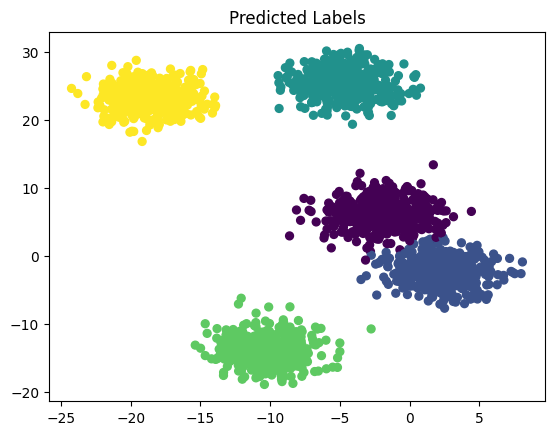

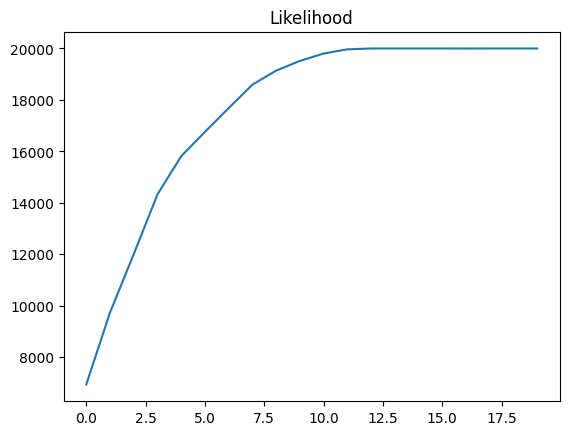

In [25]:
N_STEPS = 20

collapsed_gibbs_lda = CollapsedGibbsLDA(N_TOPICS).fit(Y, N_STEPS)
Y_labels, score = util.evaluate(X_labels, collapsed_gibbs_lda.transform(Y))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')
util.visualize_log(collapsed_gibbs_lda.likelihood_log_, 'Likelihood')

#### Pyro LDA

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 162.63it/s]


Score: 1.0


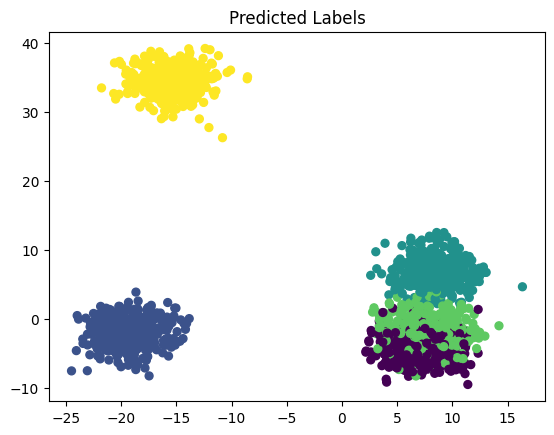

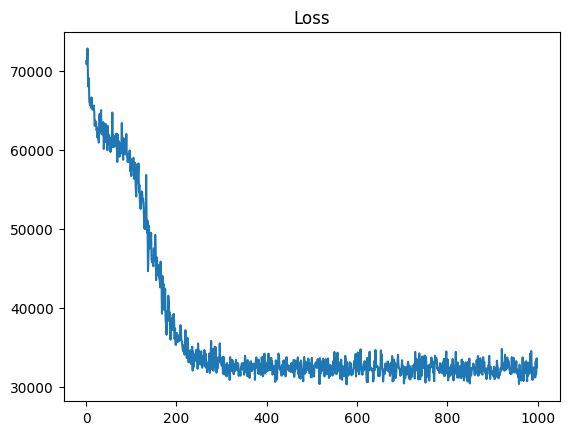

In [8]:
N_STEPS = 1000

pyro.clear_param_store()
pyro_lda = PyroLDA(N_TOPICS, batch_size=100).fit(torch.tensor(Y).T, N_STEPS, 1e-1)
Y_labels, score = util.evaluate(X_labels, pyro_lda.transform(torch.tensor(Y).T))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')
util.visualize_log(pyro_lda.loss_log_, 'Loss')